In [52]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [67]:
obs = 1000

In [54]:
samples_df = pd.DataFrame({
    'coffee_p': np.cumsum(np.random.uniform(-1,1,(obs))),
    'oil_p': np.cumsum(np.random.uniform(-1,1,(obs))),
    'event_dummy': np.concatenate(
        ([0]*int(num_samples*1/4),
         [1]*int(num_samples*1/2), 
         [0]*int(num_samples*1/4)), axis=0)})

In [55]:
print(samples_df.shape)
samples_df.head()

(1000, 3)


,coffee_p,event_dummy,oil_p
0,-0.418171,0,-0.711363
1,0.182327,0,0.068215
2,-0.444117,0,-0.028624
3,-1.089975,0,0.437469
4,-0.442432,0,0.074573


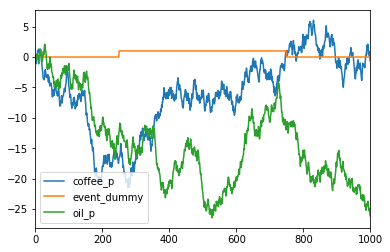

In [56]:
samples_df.plot()

In [57]:
# Regress coffee prices on event_dummy and oil prices
y = samples_df['coffee_p'].values
X = samples_df[['event_dummy', 'oil_p']].values

In [58]:
# Run OLS regresion
mod = sm.OLS(y, X)
res = mod.fit()

In [59]:
# Regression results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     370.2
Date:                Tue, 28 Nov 2017   Prob (F-statistic):          5.36e-121
Time:                        22:30:23   Log-Likelihood:                -3297.6
No. Observations:                1000   AIC:                             6599.
Df Residuals:                     998   BIC:                             6609.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -5.0133      0.424    -11.826      0.000      -5.845      -4.181
x2             0.1595      0.019      8.389      0.000       0.122       0.197
==============================================================================
Omnibus:                      114.954   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.305
Skew:                          -0.968   Prob(JB):                     1.14e-34
Kurtosis:                       2.988   Cond. No.                         32.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-stat suggests that our results are strongly significant at the 0.001 level and we have a high R-squared value suggesting we can explain a lot of the y-variable with our data.

... But this data is just noise ...

The Durbin-Watson statistic is nearly 0, which suggests very strong serial auto-correlatoin, violating the assumptions for our OLS regression

**Let's try again but with first-difference**

In [60]:
samples_df_fd = pd.DataFrame({
    'coffee_p': samples_df[['coffee_p']].diff()[1:].values.squeeze(),
    'oil_p': samples_df[['oil_p']].diff()[1:].values.squeeze(),
    'event_dummy': samples_df[['event_dummy']][1:].values.squeeze()})

In [61]:
print(samples_df_fd.shape)
samples_df_fd.head()

(999, 3)


,coffee_p,event_dummy,oil_p
0,0.600499,0,0.779577
1,-0.626445,0,-0.096839
2,-0.645858,0,0.466093
3,0.647544,0,-0.362896
4,0.854208,0,0.357120


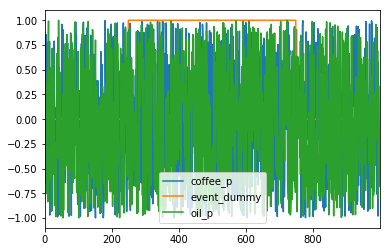

In [62]:
samples_df_fd.plot()

In [63]:
y = samples_df_fd['coffee_p'].values
X = samples_df_fd[['event_dummy', 'oil_p']].values
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.015
Date:                Tue, 28 Nov 2017   Prob (F-statistic):              0.134
Time:                        22:30:23   Log-Likelihood:                -900.64
No. Observations:                 999   AIC:                             1805.
Df Residuals:                     997   BIC:                             1815.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0354      0.027      1.327      0.185      -0.017       0.088
x2             0.0486      0.032      1.503      0.133      -0.015       0.112
==============================================================================
Omnibus:                     1220.342   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.628
Skew:                          -0.008   Prob(JB):                     5.61e-15
Kurtosis:                       1.744   Cond. No.                         1.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This time we get the expected results, the explanatory variables are just random noise and explain nothing

**Instead of looking at the Durbin-Watson statistic to realise we had serial autocorrelation, could we have just done this?**

**Consider a standard machine-learning pipeline**

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

In [65]:
# Our original data
y = samples_df['coffee_p'].values
X = samples_df[['event_dummy', 'oil_p']].values

In [68]:
# Let's split the data into train/test
y_train, y_test = y[:int(obs*0.7)], y[int(obs*0.7):]
X_train, X_test = X[:int(obs*0.7)], X[int(obs*0.7):]

In [69]:
print(len(X_test))

300


In [70]:
# Run sklearn linear regression
reg = linear_model.LinearRegression()
reg.fit(X=X_train, y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
# Predict on test-data
prediction = reg.predict(X=X_test)

In [72]:
# What's the mean-squared-error
np.sum((y_test-prediction)**2)/len(prediction)

210.42609207011822

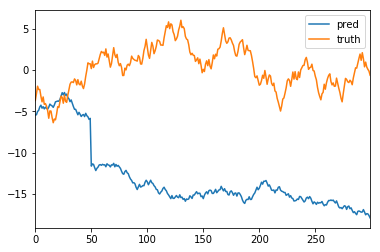

In [73]:
# Let's compare our prediction with the truth
test_df = pd.DataFrame({
    'truth': y_test,
    'pred': prediction})
test_df.plot()